# Make Prophet based models for every station

In [67]:
import json
from pathlib import Path

import statsmodels.api as sm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from prophet import Prophet, plot, diagnostics
from prophet.serialize import model_to_json, model_from_json

# %%write isn't great because it doesn't handle imports
#from load_data import load_data_local

## Make helper functions

In [3]:
def load_data_local(fname, var):
    with xr.open_dataset(fname) as ds:
        df = ds.to_dataframe()

    # Remove non-monotonic time-stamps
    # - find time diff > 2 days
    # - max in original dataset without problems of 2 days (leap year)
    ns_per_day = 86400000000000
    ndays = 2
    limit = ndays * ns_per_day
    if np.max(np.diff(df.index.values)) > limit:
        tmp_df = df.copy()
        while np.max(np.diff(tmp_df.index.values)) > limit:
            #print(np.max(np.diff(tmp_df.index.values)), np.argmax(np.diff(tmp_df.index.values)))
            drop_ix = np.argmax(np.diff(tmp_df.index.values)) + 1
            drop_time = tmp_df.iloc[drop_ix, :]
            new_df = tmp_df.drop(index=[drop_time.name])
            tmp_df = new_df
        df = tmp_df
    
    new_times = pd.date_range(start=df.index[0], end=df.index[-1], freq='D')
    new_df = df.reindex(index=new_times, columns=[var])
    new_df.fillna(method='ffill', inplace=True)
    
    return new_df

In [4]:
def load_station(station_name):
    # load ice
    ice = load_data_local(f'station-data/{station_name}-ice_conc.nc', 'ICE_C_GDS0_SFC_ave6h')
    weekly = ice.resample('W').mean()
    weekly.rename(columns={'ICE_C_GDS0_SFC_ave6h': 'y'}, inplace=True)
    weekly.reset_index(inplace=True)
    weekly.rename(columns={'index': 'ds'}, inplace=True)
    
    # load temp
    temp = load_data_local(f'station-data/{station_name}-atm_temp.nc', 'POT_GDS0_DBSL_ave6h')
    temp_weekly = temp.resample('W').mean()
    weekly['air-temp'] = temp_weekly['POT_GDS0_DBSL_ave6h'].values
    
    # add floor + cap
    weekly['cap'] = 1.0
    weekly['floor'] = 0.0
    
    return weekly

In [5]:
def get_stations(data_dir='/data/assets/s2s/data-exploration/station-data'):
    station_files = Path(data_dir).glob('*.nc')
    stations = [f.name.split('.')[0].split('-')[0] for f in station_files]
    
    return list(set(stations))

In [6]:
def build_model(df):
    model = Prophet(
        growth='logistic',
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays=None,
        seasonality_mode='multiplicative',
        changepoint_range=0.9
    )
    model.add_regressor('air-temp', standardize=False)
    model.fit(df)
    
    return model

In [7]:
def evaluate_model(model):
    df_cv = diagnostics.cross_validation(
        model,
        cutoffs=pd.to_datetime(['2020-01-01']),
        horizon='365 days'
    )
    df_p = diagnostics.performance_metrics(df_cv)
    return df_p

In [8]:
def save_model(model, out_dir, station):
    out_file = out_dir / f'{station}-model.json'
    with open(out_file, 'w') as fout:
        json.dump(model_to_json(model), fout)

## Create the models for each station

In [9]:
out_dir = Path('station-models')
out_dir.mkdir(exist_ok=True)

In [10]:
stations = get_stations()

In [11]:
# takes ~20 minutes, could easily be redone with Dask to take < 1 m
rerun = False

if rerun:
    station_stats = {}
    for station in stations:
        try:
            df = load_station(station)
            model = build_model(df)
            stats = evaluate_model(model)
            station_stats[station] = stats
            print(f"{station=}: RMSE:{stats['rmse'].mean()}")
            save_model(model, out_dir, station)
        except:
            print(f'ERROR: {station}')

## Evaluate model stats

In [12]:
if rerun:
    for station in stations:
        try:
            out_file = out_dir / f'{station}-stats.csv'
            station_stats[station].to_csv(out_file)
        except:
            continue
else:
    station_stats = {}
    for station in stations:
        try:
            stat_file = out_dir / f'{station}-stats.csv'
            df = pd.read_csv(stat_file)
            station_stats[station] = df
        except:
            print(f'ERROR: {station}')

ERROR: PATGC
ERROR: PAMYC
ERROR: PAUNC
ERROR: PASCC


### RMSE for every station

In [13]:
print(f'{"station":10}: {"min":4} {"max":4} {"mean":4}')
print(f'{"-"*26}')

for station in stations:
    try:
        rmse = station_stats[station]['rmse']
        print(f'{station:10}: {rmse.min():.02f} {rmse.max():.02f} {rmse.mean():.02f}')
    except:
        continue

station   : min  max  mean
--------------------------
MRSTC     : 0.00 0.68 0.22
N64W1675  : 0.00 0.55 0.15
N63W173   : 0.00 0.76 0.24
N73W145   : 0.03 0.76 0.26
N63W171   : 0.00 0.69 0.22
PABA20    : 0.00 0.42 0.15
N72W1675  : 0.01 0.34 0.16
N714W1575 : 0.00 0.21 0.09
PASN10    : 0.02 0.02 0.02
PLPT20    : 0.00 0.68 0.15
N72W155   : 0.00 0.52 0.13
YKRDC     : 0.00 0.49 0.18
PAPH20    : 0.02 0.23 0.05
DMPT10    : 0.00 0.26 0.09
N628W1663 : 0.00 0.58 0.18
NSLG10    : 0.01 0.02 0.01
N56W167   : 0.00 0.00 0.00
PATG10    : 0.00 0.55 0.13
N57W177   : 0.00 0.00 0.00
N74W165   : 0.00 0.38 0.13
PAPOC     : 0.00 0.42 0.16
CMPTC     : 0.00 0.22 0.08
PTTPC     : 0.01 0.25 0.09
N57W161   : 0.01 0.02 0.02
N74W155   : 0.05 0.63 0.19
N713W160  : 0.00 0.32 0.13
N76W170   : 0.04 0.36 0.13
N63W175   : 0.00 0.74 0.25
N55W169   : 0.00 0.00 0.00
N58W175   : 0.01 0.01 0.01
N75W1625  : 0.05 0.47 0.15
PAGM10    : 0.00 0.76 0.24
N61W169   : 0.00 0.60 0.18
N57W1687  : 0.02 0.02 0.02
N57W165   : 0.03 0.17 0.05
N

### Plot of metrics over horizon

In [14]:
horizon = [int(h.split(' ')[0]) for h in station_stats['N76W155']['horizon']]
horizon[:5]

[32, 39, 46, 53, 60]

Text(0, 0.5, 'MSE')

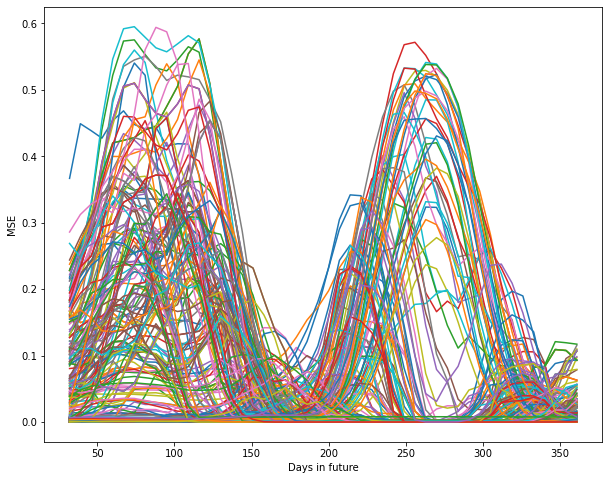

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
for station in stations:
    try:
        ax.plot(
            horizon,
            station_stats[station]['mse']
        )
    except:
        continue
ax.set_xlabel('Days in future')
ax.set_ylabel('MSE')

Text(0, 0.5, 'RMSE')

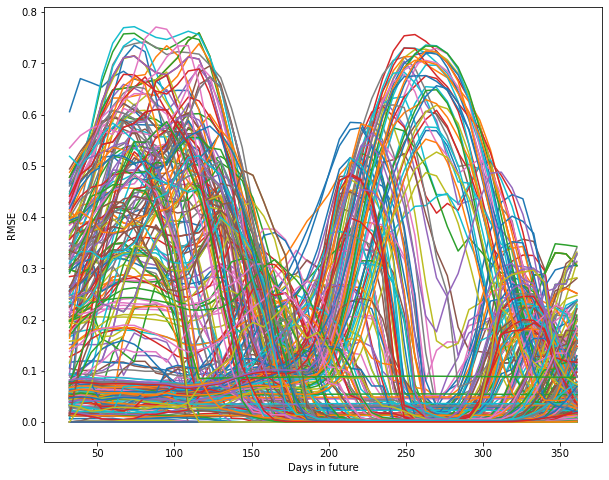

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
for station in stations:
    try:
        ax.plot(
            horizon,
            station_stats[station]['rmse']
        )
    except:
        continue
ax.set_xlabel('Days in future')
ax.set_ylabel('RMSE')

Text(0, 0.5, 'Mean Absolute Error (MAE)')

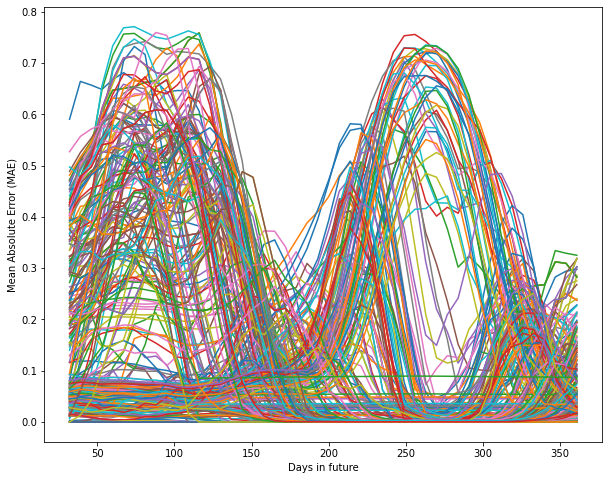

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
for station in stations:
    try:
        ax.plot(
            horizon,
            station_stats[station]['mae']
        )
    except:
        continue
ax.set_xlabel('Days in future')
ax.set_ylabel('Mean Absolute Error (MAE)')

### Investigate RMSE mode groups

Looks like there are a few groupings:
- Early (peak around 100 days)
- Small mid (peak around 150 days)
- Small late mid (peak around 225 days)
- Late (peak around 275 days)
- Small late (peak around 325 days)
- Small very late (Peak at end of year)

The large errors are all associated with phase differences in local freezing and thawing.

In [18]:
max_day = {}
for station in stations:
    try:
        max_ix = np.argmax(station_stats[station]['rmse'])
        max_day[station] = horizon[max_ix]
    except:
        continue

Text(0.5, 0, 'Day of forecast')

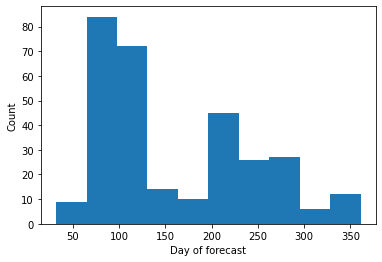

In [19]:
plt.hist([v for v in max_day.values()])
plt.ylabel('Count')
plt.xlabel('Day of forecast')

In [20]:
# early date
station_stats['PAOT']

,Unnamed: 0,horizon,mse,rmse,mae,mdape,smape,coverage
0,0,32 days,0.064297,0.253569,0.249258,0.272064,0.326930,0.0
1,1,39 days,0.072829,0.269869,0.263386,0.272064,0.338123,0.0
2,2,46 days,0.083644,0.289213,0.282855,0.332261,0.355844,0.0
3,3,53 days,0.092607,0.304314,0.302084,0.332261,0.375627,0.0
4,4,60 days,0.101896,0.319212,0.318622,0.332261,0.392068,0.0
5,5,67 days,0.101215,0.318143,0.317568,0.331321,0.390600,0.0
6,6,74 days,0.096378,0.310448,0.309970,0.329005,0.382260,0.0
7,7,81 days,0.090589,0.300980,0.300401,0.310456,0.371101,0.0
8,8,88 days,0.090080,0.300133,0.299488,0.310456,0.368571,0.0
9,9,95 days,0.079763,0.282423,0.280753,0.292539,0.348767,0.0


#### Early model station example for 1 year prediction.

This is the result of the leading or lagging edge of ice freeze or melt compared to the model predictions.
There is not enough information in ice history and air temperature to make good predicitons there.

In [21]:
station = 'PAOT'
df = load_station(station)
model = build_model(df)
stats = evaluate_model(model)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


In [22]:
# Add air for future from last year available.
# - this is bogus
future = model.make_future_dataframe(52, freq='W')
future['cap'] = 1
future['floor'] = 0
# copy temp from last year for first attempt of adding
future['air-temp'] = df['air-temp'].copy()
guess_temp = df['air-temp'].iloc[-52::].values.copy()
future['air-temp'].iloc[-52::] = guess_temp

/env/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


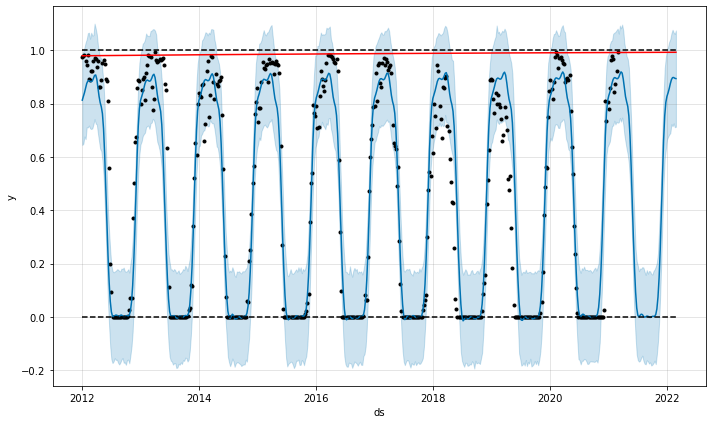

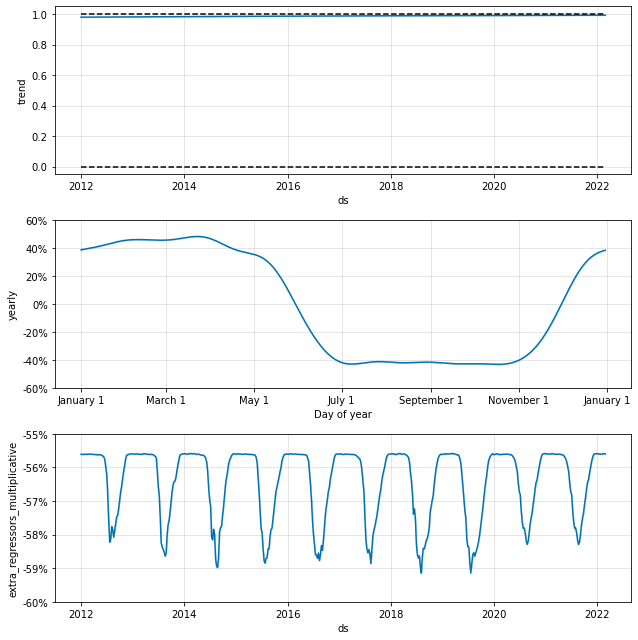

INFO:prophet:Making 3 forecasts with cutoffs between 2019-03-06 00:00:00 and 2020-02-29 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


count    143.000000
mean       0.259395
std        0.068523
min        0.114915
25%        0.216014
50%        0.256750
75%        0.330568
max        0.353800
Name: rmse, dtype: float64


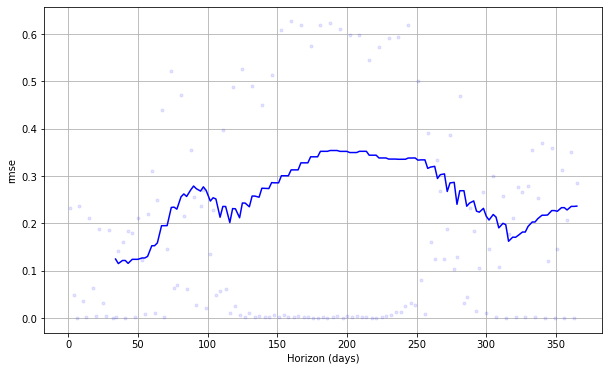

In [41]:
forecast = model.predict(future)
fig1 = model.plot(forecast)
a = plot.add_changepoints_to_plot(fig1.gca(), model, forecast)
fig2 = model.plot_components(forecast)
plt.show()

df_cv = diagnostics.cross_validation(
    model,
    initial=f'{365 * 7} days',
    period='180 days',
    horizon='365 days'
)
plot.plot_cross_validation_metric(df_cv, metric='rmse')
df_p = diagnostics.performance_metrics(df_cv)
print(f"{df_p['rmse'].describe()}")

In [93]:
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,34 days,0.015492,0.124467,0.082909,0.219828,0.765061,0.666667
1,36 days,0.013205,0.114915,0.076788,0.196669,0.758529,0.733333
2,39 days,0.014755,0.121471,0.084251,0.219828,0.771751,0.666667
3,41 days,0.014755,0.121471,0.084225,0.219828,0.771751,0.666667
4,43 days,0.013309,0.115363,0.080777,0.206139,0.768755,0.666667
...,...,...,...,...,...,...,...
138,356 days,0.054317,0.233061,0.182931,0.364573,0.894092,0.466667
139,358 days,0.052078,0.228206,0.178281,0.364573,0.888579,0.466667
140,361 days,0.055582,0.235758,0.183958,0.364573,0.894228,0.466667
141,363 days,0.055581,0.235757,0.183802,0.364573,0.894228,0.466667


Text(0, 0.5, 'Air Temp (K)')

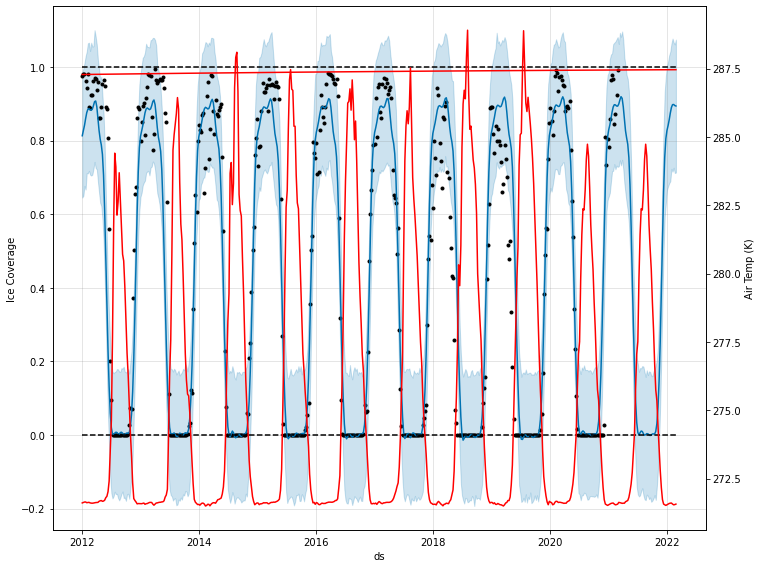

In [94]:
fig, ax = plt.subplots(figsize=(10, 8))
model.plot(forecast, ax=ax)
plot.add_changepoints_to_plot(fig.gca(), model, forecast)
ax.set_ylabel('Ice Coverage')

ax2 = ax.twinx()
ax2.plot(forecast['ds'], future['air-temp'], color='r')
ax2.set_ylabel('Air Temp (K)')

Text(0, 0.5, 'Ice Concentration')

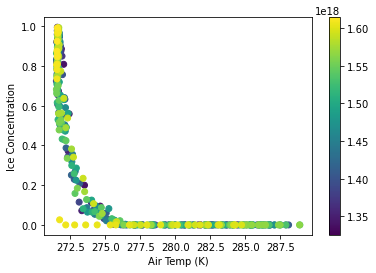

In [65]:
plt.scatter(df['air-temp'], df['y'], c=df['ds'])
plt.colorbar()
plt.xlabel('Air Temp (K)')
plt.ylabel('Ice Concentration')

#### Compare with linear model of air temp vs. ice concentration at a station (again)

How much can we get from just regressing air temperature and sea ice.

R-squared is 0.636 which means that air temperature explains 64% of the uncertainty
of the ice.  So, the 

Text(0, 0.5, 'Ice Concentration')

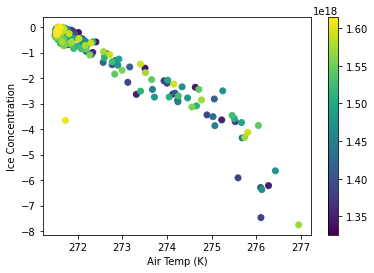

In [75]:
plt.scatter(df['air-temp'], np.log(df['y']), c=df['ds'])
plt.colorbar()
plt.xlabel('Air Temp (K)')
plt.ylabel('Ice Concentration')

In [146]:
X = np.log(df['air-temp'].values)
X = sm.add_constant(X)
y = df['y'].values

results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     850.4
Date:                Thu, 10 Jun 2021   Prob (F-statistic):          4.46e-108
Time:                        20:55:13   Log-Likelihood:                -10.200
No. Observations:                 479   AIC:                             24.40
Df Residuals:                     477   BIC:                             32.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         97.6599      3.334     29.293      0.0

In [137]:
results.predict([1, np.log(272)])

array([0.66832976])

In [150]:
# RMSE for 2020
mask = np.logical_and(df['ds'] > '2020-01-01', df['ds'] < '2021-01-01')
air_2020 = df['air-temp'].values[mask]
ice_2020 = df['y'].values[mask]

X2 = np.vstack([
    np.ones_like(air_2020),
    np.log(air_2020)
]).T

preds = results.predict(X2)
preds

array([ 0.69142228,  0.69251956,  0.6974367 ,  0.69624867,  0.69161204,
        0.68924422,  0.68978874,  0.69215655,  0.69160379,  0.69188429,
        0.69251956,  0.69324558,  0.69415311,  0.69369935,  0.69388085,
        0.690424  ,  0.68906272,  0.68751167,  0.68032572,  0.66651483,
        0.64925534,  0.62259059,  0.57905411,  0.53174728,  0.42783559,
        0.34986264,  0.32134159,  0.17791129,  0.07909   ,  0.02077735,
        0.02349168, -0.02118333, -0.08916525, -0.12331296, -0.09673071,
       -0.02668623,  0.05749089,  0.1110844 ,  0.15752496,  0.23170281,
        0.29312579,  0.37093374,  0.43150695,  0.45635665,  0.51543656,
        0.56730578,  0.61724444,  0.65770358,  0.68560587,  0.69579491,
        0.6974367 ,  0.69897949])

In [153]:
rmse = np.sqrt((preds - ice_2020)**2)
rmse.min(), rmse.max(), rmse.mean()

(0.020777354609620602, 0.6598915818574795, 0.24131417256838142)

In [155]:
df_p['rmse'].min(), df_p['rmse'].max(), df_p['rmse'].mean()

(0.1149148993568064, 0.3538003468542443, 0.2593949371071914)